In [1]:
import pandas as pd
# df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/testing/results/jakarta_mini_inf_metadata_20250813-092915.csv")
# df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/testing/results/jakarta_inf_metadata_ratio_cutoff_20250813-130617.csv")
# df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/testing/results/jakarta_inf_metadata_20250813-105145.csv")
# df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/testing/results/jakarta_inf_metadata_reasonable_ratio_20250814-101727.csv")
df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/j2_08-14-11:36.csv")
df.head()

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed,inf_lanes,osm_lanes,osm_highway,count,min_s,max_s,q1,q2,q3,uv_vu
0,7117954741,6472266780,0,761832568,False,True,64.74,70,NaN,23,1.0,primary,260727,0.0,120.00,59.89,64.74,69.23,"(143190, 116068)"
1,12031761368,1697174400,0,140793212,True,True,39.05,50,NaN,2,2.0,primary,2348,0.0,120.00,36.52,39.05,46.89,"(1856, 189)"
2,1697174400,5488085216,0,140793212,True,True,12.61,20,NaN,1,2.0,primary,3203,0.0,103.08,9.39,12.61,13.68,"(2709, 283)"
3,5488085216,5488085215,0,570892419,True,True,10.32,50,NaN,1,1.0,primary_link,350,0.0,45.59,7.52,10.32,19.76,"(171, 72)"
4,5488085216,360587100,0,140793212,True,True,19.58,70,NaN,1,2.0,primary,626,0.0,61.45,17.29,19.58,25.18,"(336, 127)"


### Inferred Oneway

#### Accuracy

In [2]:
accuracy_with_na = (df['inf_oneway'] == df['osm_oneway']).mean()
df = df.dropna(subset='inf_oneway')
accuracy_wout_na = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy:\n\twith NA vals: {accuracy_with_na}\n\tw/o NA vals: {accuracy_wout_na}")

Accuracy:
	with NA vals: 0.25
	w/o NA vals: 0.6545454545454545


In [3]:
def resolve_oneway(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return False
# Group by 'osmid' and apply logic to 'oneway'
result = df.groupby('osmid')['inf_oneway'].apply(resolve_oneway).reset_index()
result

def resolve_oneway_osm(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return None

agg_result = df.groupby('osmid').agg({
    'inf_oneway': resolve_oneway,
    'osm_oneway': resolve_oneway_osm
}).reset_index()

agg_result

accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6545


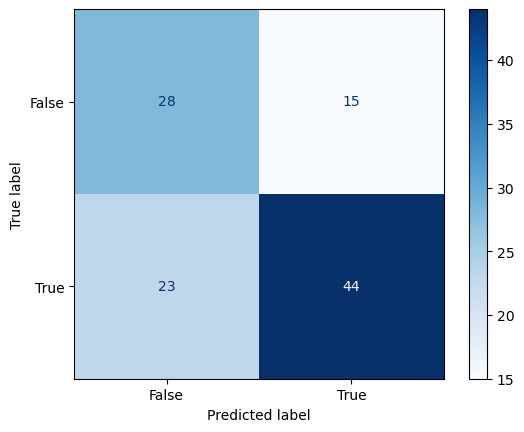

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
df_nona = df.dropna(subset=['inf_oneway'])
cm = confusion_matrix(list(df['osm_oneway']), list(df_nona['inf_oneway']))
labels = sorted(df['osm_oneway'].unique()) 
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(cmap='Blues')

Confusion Matrix results (True Negatives , True Positives) (False Negatives , False Positives)
* jakarta_mini_inf_metadata_20250813-092915.csv:                  
    * (0, 27) (7, 4)
* jakarta_inf_metadata_20250813-105145.csv:                  
    * (93, 81) (184, 167)
* jakarta_inf_metadata_ratio_cutoff_20250813-130617.csv:          
    * (27, 46) (21, 16)
* jakarta_inf_metadata_reasonable_ratio_20250814-101727.csv:      
    *   (31, 42) (25, 12)

#### False Positives/Negatives

In [5]:
# FUNC plot_counts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast

def plot_counts(df, ax, title, xscale='linear', yscale='linear'):
    tuples = df['uv_vu'].apply(ast.literal_eval)
    uv = tuples.str[0]
    vu = tuples.str[1]

    ax.scatter(uv, vu, alpha = 0.7)

    ax.set_ylabel('v -> u')
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.grid(True)

    ax.axline((0,0), slope=1, color='red', linestyle='--', linewidth=1, label="x=y")
    ax.legend()

In [6]:
# SUBSETTING BY confusion matrix categories
false_negatives = df[~df['inf_oneway'] & df['osm_oneway']]
false_positives = df[df['inf_oneway'] & ~df['osm_oneway']]
true_negatives = df[~df['inf_oneway'] & ~df['osm_oneway']]
true_positives = df[df['inf_oneway'] & df['osm_oneway']]

In [41]:
# SUBSETTING false negatives
import numpy as np

false_negatives_cut = false_negatives[false_negatives['count'] < 2000]

tups = false_negatives_cut['uv_vu'].apply(ast.literal_eval)
fn_uv = tups.str[0]
fn_vu = tups.str[1]

ratio = []
for uv, vu in zip(fn_uv, fn_vu):
    min_val = min(uv, vu)
    max_val = max(uv, vu)
    ratio.append(min_val/max_val)

    # print(f"a: {min_val}\tb: {max_val}\ta/b: {round(min_val/max_val, 3)}")
false_negatives_cut['ratio'] = ratio
false_negatives_reasonable_ratio = false_negatives_cut[false_negatives_cut['ratio'] >= 0.55]
false_negatives_bad = false_negatives_cut[false_negatives_cut['ratio'] < 0.5]

# SUBSETTING false positives
false_positives_cut = false_positives[false_positives['count'] < 2000]

# tups = false_positives_cut['uv_vu'].apply(ast.literal_eval)
# fn_uv = tups.str[0]
# fn_vu = tups.str[1]

# ratio = []
# for uv, vu in zip(fn_uv, fn_vu):
#     min_val = min(uv, vu)
#     max_val = max(uv, vu)
#     ratio.append(min_val/max_val)

# false_positives_cut['ratio'] = ratio
false_positives_reasonable_sample_size = false_positives_cut[false_positives_cut['count'] >= 11]
# false_positives_reasonable_ratio = false_positives_cut[false_positives_cut['ratio'] >= 0.55]
# false_negatives_bad = false_negatives_cut[false_negatives_cut['ratio'] < 0.5]

/tmp/ipykernel_311554/3927421785.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_cut['ratio'] = ratio


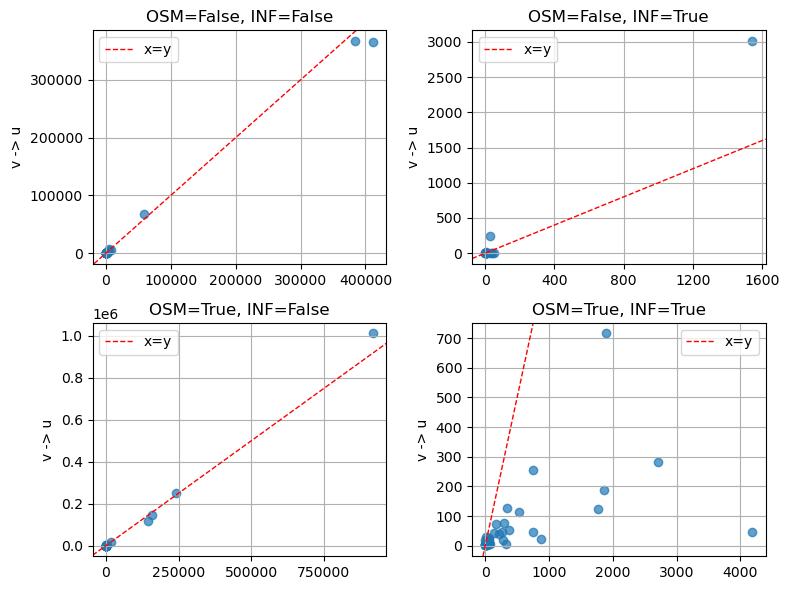

In [16]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
plot_counts(true_negatives, axes[0,0], 'OSM=False, INF=False')
plot_counts(false_positives, axes[0,1], 'OSM=False, INF=True')
plot_counts(false_negatives, axes[1,0],'OSM=True, INF=False')
plot_counts(true_positives, axes[1,1], 'OSM=True, INF=True')
fig.set_tight_layout(tight=True)

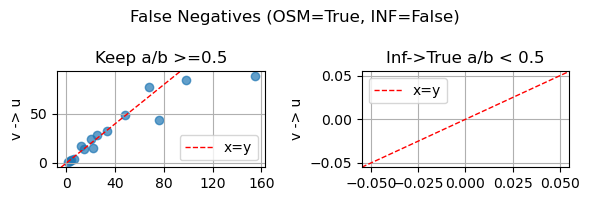

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(6,2))
fig.suptitle("False Negatives (OSM=True, INF=False)")
plot_counts(false_negatives_reasonable_ratio, axes[0],'Keep a/b >=0.55')
plot_counts(false_negatives_bad, axes[1], 'Inf->True a/b < 0.5')
fig.set_tight_layout(tight=True)

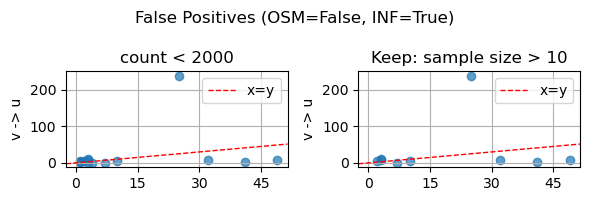

In [42]:
fig, axes = plt.subplots(1,2, figsize=(6,2))
fig.suptitle("False Positives (OSM=False, INF=True)")
plot_counts(false_positives_cut, axes[0],'count < 2000')
plot_counts(false_positives_reasonable_sample_size, axes[1], 'Keep: sample size > 10')
fig.set_tight_layout(tight=True)

### Inferred Speed Limit

In [153]:
osm_highway_vals = df['osm_highway'].value_counts()

In [154]:
primary = df[df['osm_highway'] == 'primary'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]
residential = df[df['osm_highway'] == 'residential'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]
secondary = df[df['osm_highway'] == 'secondary'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]
living_street = df[df['osm_highway'] == 'living_street'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]
tertiary = df[df['osm_highway'] == 'tertiary'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]
primary_link = df[df['osm_highway'] == 'primary_link'][['inf_speed_limit', 'osm_maxspeed', 'q1', 'q2', 'q3']]

<ErrorbarContainer object of 3 artists>

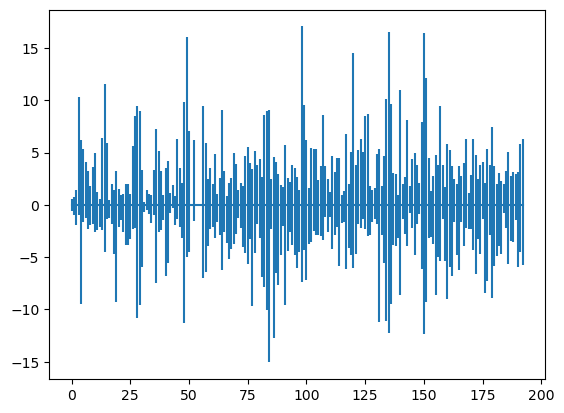

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 4))
sub = primary

def plot_speed_spread(sub, ax):
    lower_err = np.abs(sub['q1'] - sub['q2'])
    upper_err = np.abs(sub['q3'] - sub['q2'])
    ax.errorbar(x=np.arange(0, 193), y=np.zeros_like(sub['q2']), yerr=[lower_err, upper_err])
    ax.xlabel()
    
    # ax.set_ylabel('v -> u')
    # ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.grid(True)

    ax.axline((0,0), slope=1, color='red', linestyle='--', linewidth=1, label="x=y")
    ax.legend()


<ErrorbarContainer object of 3 artists>

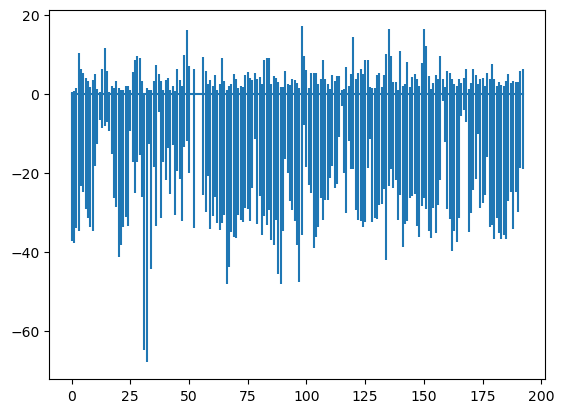

In [182]:
lower_err = np.abs(sub['q1'] - sub['q2'])
upper_err = np.abs(sub['q3'] - sub['q2'])
plt.errorbar(x=np.arange(0, 193), y=np.zeros_like(sub['q2']), yerr=[sub['q1'], upper_err])

<ErrorbarContainer object of 3 artists>

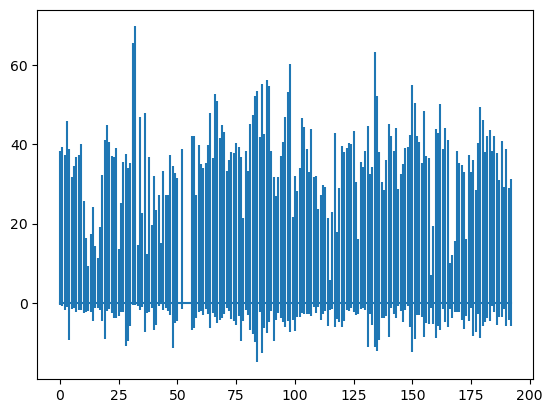

In [183]:
lower_err = np.abs(sub['q1'] - sub['q2'])
upper_err = np.abs(sub['q3'] - sub['q2'])
plt.errorbar(x=np.arange(0, 193), y=np.zeros_like(sub['q2']), yerr=[lower_err, sub['q3']])

In [180]:
lower_err

0      0.63
1      0.93
2      1.92
3      1.00
4      9.49
       ... 
361    3.55
372    1.44
386    5.93
387    4.46
388    5.78
Length: 193, dtype: float64

In [181]:
upper_err

0       0.55
1       0.78
2       1.43
3      10.36
4       6.24
       ...  
361     3.18
372     2.95
386     3.12
387     5.82
388     6.31
Length: 193, dtype: float64

### Number of Lanes